In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [2]:
random.seed = 20

In [3]:
# Get load Boolean index
file_path = f'../../data/IEEE_Case118/zones/load_bus.csv'
load_buses = pd.read_csv(file_path, index_col=None, header=None)

load_bidx = np.isin(np.arange(1, 119), load_buses)

## Load model

In [4]:
# Root
from GNNLoadRegressor import DLANN, DLSAGE, DLGCN
from MyDataset import MyDataset

## Set parameters

In [5]:
# Set hyper-parameters
input_dim = 32
hidden_dim = 256
output_dim = 12

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## ANN

In [6]:
root = '../../train_val_test_dataset/IEEE_Case118/DL-ANN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = DLANN(input_dim, hidden_dim, output_dim)
model.to(device)

DLANN(
  (ann): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=12, bias=True)
  )
)

#### ANN model training

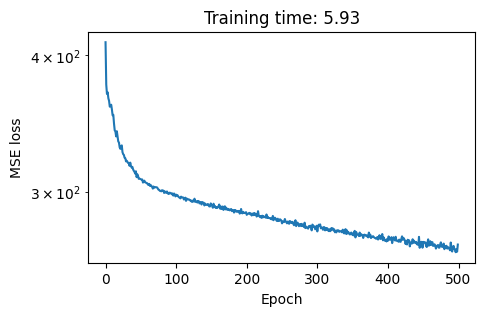

In [7]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index, load_bidx)

        loss = F.mse_loss(y_pred, loader.y[load_bidx])

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save ANN model

In [8]:
torch.save(model, './trained_model/DLANN_model.pt')

#### ANN model testing

In [9]:
# Get train dataset
test_size = 200
test_dataset = dataset[-test_size:]
# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()[load_bidx]
        # Save ground true
        file_path = f'./model_evaluation/ANN/DL_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index, load_bidx)
        pred = pred.detach().numpy()

        # Save prediction
        file_path = f'./model_evaluation/ANN/DL_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)

## SAGE

In [10]:
root = '../../train_val_test_dataset/IEEE_Case118/DL-SAGE'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = DLSAGE(input_dim, hidden_dim, output_dim)
model.to(device)

DLSAGE(
  (gnn): Sequential(
    (0): SAGEConv(32, 256, aggr=mean)
    (1): ReLU()
    (2): SAGEConv(256, 256, aggr=mean)
    (3): ReLU()
    (4): SAGEConv(256, 12, aggr=mean)
  )
)

#### SAGE model training

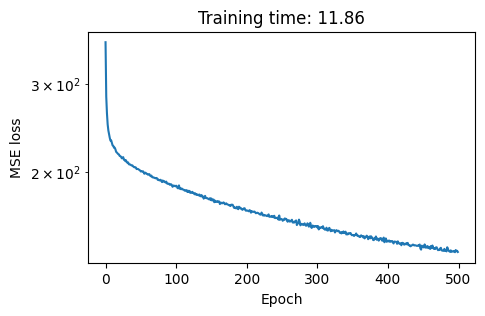

In [11]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index, load_bidx)

        loss = F.mse_loss(y_pred, loader.y[load_bidx])

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save SAGE model

In [12]:
torch.save(model, './trained_model/DLSAGE_model.pt')

#### SAGE model testing

In [13]:
# Get train dataset
test_size = 200
test_dataset = dataset[-test_size:]
# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()[load_bidx]
        # Save ground true
        file_path = f'./model_evaluation/SAGE/DL_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index, load_bidx)
        pred = pred.detach().numpy()

        # Save prediction
        file_path = f'./model_evaluation/SAGE/DL_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)

## GCN

In [14]:
root = '../../train_val_test_dataset/IEEE_Case118/DL-GCN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = DLGCN(input_dim, hidden_dim, output_dim)
model.to(device)

DLGCN(
  (gnn): Sequential(
    (0): GCNConv(32, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 12)
  )
)

#### GCN model training

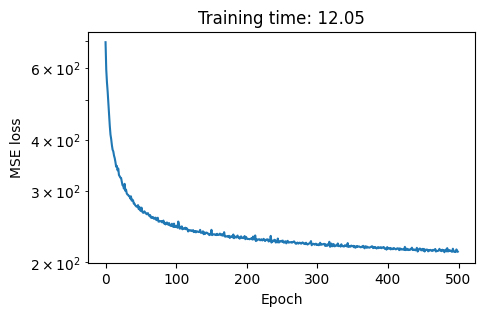

In [15]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index, load_bidx)

        loss = F.mse_loss(y_pred, loader.y[load_bidx])

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save GCN model

In [16]:
torch.save(model, './trained_model/DLGAN_model.pt')

#### GCN model testing

In [17]:
# Get train dataset
test_size = 200
test_dataset = dataset[-test_size:]
# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()[load_bidx]
        # Save ground true
        file_path = f'./model_evaluation/GCN/DL_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index, load_bidx)
        pred = pred.detach().numpy()

        # Save prediction
        file_path = f'./model_evaluation/GCN/DL_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)